In [1]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

# 05/02/2025

# Continuing the examination of the PKPD curves of different weight groups to figure out where the bug is

<br>

---

<br>

# Objective 1: Adjusting the PMF and studying its effect on efficacy

<br>

---
    
# Using previously calibrated --pmax_artemether 0.9999994 and --ec50_lum 64 values

--- 

### Function call to examine state values of one weight group

#### Editing it to give efficacy for weight = 10Kg with a range of PMFs

In [51]:
# Function to run a single simulation for a given pmf value

def run_single_pmf_simulation(weight, pmf):
    start_time = time.monotonic()
    command_pmf = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "64",
        "--pmf", str(pmf),
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_pmf = subprocess.run(command_pmf, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmf = output_pmf.stdout.splitlines()
        df_pmf = pd.DataFrame([line.split() for line in lines_pmf], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmf = df_pmf.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_pmf['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_pmf[(df_pmf['PARASITEDENSITY'] >= 10) & (df_pmf['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_pmf['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_pmf, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}Kg, pmf: {pmf}: \n {e}\n")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}Kg, pmf: {pmf}: \n{e}\n")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [52]:
# Genrating range of pmf values
weight = 10

min_pmf = 2
max_pmf = 22

pmf_values = np.arange(min_pmf, max_pmf, 2)

print(pmf_values)

np.savetxt(f"pmf_values_{weight}Kg.txt", pmf_values, fmt='%d')

weight = 10
efficacy_results = []
failed_treatment_count_results = []

[ 2  4  6  8 10 12 14 16 18 20]


In [54]:
for pmf in pmf_values:

    # Remove the previous files if they exist
    params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
    if os.path.isfile(params_file_artemether):
        os.remove(params_file_artemether)

    params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
    if os.path.isfile(params_file_lumefantrine):
        os.remove(params_file_lumefantrine)
    
    killing_constant_file_artemether = f"parasite_killing_constant_{weight}kg_artemether.txt"
    if os.path.isfile(killing_constant_file_artemether):
        os.remove(killing_constant_file_artemether)
    
    killing_constant_file_lumefantrine = f"parasite_killing_constant_{weight}kg_lumefantrine.txt"
    if os.path.isfile(killing_constant_file_lumefantrine):
        os.remove(killing_constant_file_lumefantrine)
        
    efficacy, df_weight, failed_treatment_count = run_single_pmf_simulation(weight, pmf)

    # Save the DataFrame to a pickle file
    df_weight.to_pickle(f"df_weight_{weight}Kg_pmf_{pmf}.pyobj")

    # Save the DataFrame to a CSV file
    df_weight.to_csv(f"df_weight_{weight}Kg_pmf_{pmf}.csv", index=False)
    print(f"\nThe failed treatment count for weight {weight}Kg with PMF {pmf} is:", failed_treatment_count)
    print(f"\nThe percentage efficacy for weight {weight}Kg with PMF {pmf} is:", efficacy, "\n")
    
    efficacy_results.append(efficacy)
    failed_treatment_count_results.append(failed_treatment_count)

# Convert the efficacy results to a DataFrame
df_efficacy = pd.DataFrame({
"PMF": pmf_values,
"Efficacy": efficacy_results,
"Failed_Treatement_Count": failed_treatment_count_results
})

df_efficacy.to_csv(f"efficacy_results_{weight}Kg_pmf.csv", index=False)


Today's date:  2025-05-02 

Length of simulation:  0:00:28.691398 


The failed treatment count for weight 10Kg with PMF 2 is: 11

The percentage efficacy for weight 10Kg with PMF 2 is: 98.9 


Today's date:  2025-05-02 

Length of simulation:  0:00:30.740851 


The failed treatment count for weight 10Kg with PMF 4 is: 373

The percentage efficacy for weight 10Kg with PMF 4 is: 62.7 


Today's date:  2025-05-02 

Length of simulation:  0:00:28.946705 


The failed treatment count for weight 10Kg with PMF 6 is: 398

The percentage efficacy for weight 10Kg with PMF 6 is: 60.199999999999996 


Today's date:  2025-05-02 

Length of simulation:  0:00:28.873816 


The failed treatment count for weight 10Kg with PMF 8 is: 430

The percentage efficacy for weight 10Kg with PMF 8 is: 57.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:27.747041 


The failed treatment count for weight 10Kg with PMF 10 is: 438

The percentage efficacy for weight 10Kg with PMF 10 is: 56.2 


Today's d

### Weight = 20 Kg

In [56]:
weight = 20
efficacy_results = []
failed_treatment_count_results = []

for pmf in pmf_values:

    # Remove the previous files if they exist
    params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
    if os.path.isfile(params_file_artemether):
        os.remove(params_file_artemether)

    params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
    if os.path.isfile(params_file_lumefantrine):
        os.remove(params_file_lumefantrine)
    
    killing_constant_file_artemether = f"parasite_killing_constant_{weight}kg_artemether.txt"
    if os.path.isfile(killing_constant_file_artemether):
        os.remove(killing_constant_file_artemether)
    
    killing_constant_file_lumefantrine = f"parasite_killing_constant_{weight}kg_lumefantrine.txt"
    if os.path.isfile(killing_constant_file_lumefantrine):
        os.remove(killing_constant_file_lumefantrine)
        
    efficacy, df_weight, failed_treatment_count = run_single_pmf_simulation(weight, pmf)

    # Save the DataFrame to a pickle file
    df_weight.to_pickle(f"df_weight_{weight}Kg_pmf_{pmf}.pyobj")

    # Save the DataFrame to a CSV file
    df_weight.to_csv(f"df_weight_{weight}Kg_pmf_{pmf}.csv", index=False)
    print(f"\nThe failed treatment count for weight {weight}Kg with PMF {pmf} is:", failed_treatment_count)
    print(f"\nThe percentage efficacy for weight {weight}Kg with PMF {pmf} is:", efficacy, "\n")

    efficacy_results.append(efficacy)
    failed_treatment_count_results.append(failed_treatment_count)

# Convert the efficacy results to a DataFrame
df_efficacy = pd.DataFrame({
"PMF": pmf_values,
"Efficacy": efficacy_results,
"Failed_Treatement_Count": failed_treatment_count_results
})

df_efficacy.to_csv(f"efficacy_results_{weight}Kg_pmf.csv", index=False)


Today's date:  2025-05-02 

Length of simulation:  0:00:27.827233 


The failed treatment count for weight 20Kg with PMF 2 is: 0

The percentage efficacy for weight 20Kg with PMF 2 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:27.375441 


The failed treatment count for weight 20Kg with PMF 4 is: 7

The percentage efficacy for weight 20Kg with PMF 4 is: 99.3 


Today's date:  2025-05-02 

Length of simulation:  0:00:30.750141 


The failed treatment count for weight 20Kg with PMF 6 is: 15

The percentage efficacy for weight 20Kg with PMF 6 is: 98.5 


Today's date:  2025-05-02 

Length of simulation:  0:00:27.037547 


The failed treatment count for weight 20Kg with PMF 8 is: 24

The percentage efficacy for weight 20Kg with PMF 8 is: 97.6 


Today's date:  2025-05-02 

Length of simulation:  0:00:25.309626 


The failed treatment count for weight 20Kg with PMF 10 is: 28

The percentage efficacy for weight 20Kg with PMF 10 is: 97.2 


Today's date:  2025-05-02 



### Weight = 30 Kg

In [58]:
weight = 30
efficacy_results = []
failed_treatment_count_results = []

for pmf in pmf_values:

    # Remove the previous files if they exist
    params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
    if os.path.isfile(params_file_artemether):
        os.remove(params_file_artemether)

    params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
    if os.path.isfile(params_file_lumefantrine):
        os.remove(params_file_lumefantrine)
    
    killing_constant_file_artemether = f"parasite_killing_constant_{weight}kg_artemether.txt"
    if os.path.isfile(killing_constant_file_artemether):
        os.remove(killing_constant_file_artemether)
    
    killing_constant_file_lumefantrine = f"parasite_killing_constant_{weight}kg_lumefantrine.txt"
    if os.path.isfile(killing_constant_file_lumefantrine):
        os.remove(killing_constant_file_lumefantrine)
        
    efficacy, df_weight, failed_treatment_count = run_single_pmf_simulation(weight, pmf)

    # Save the DataFrame to a pickle file
    df_weight.to_pickle(f"df_weight_{weight}Kg_pmf_{pmf}.pyobj")

    # Save the DataFrame to a CSV file
    df_weight.to_csv(f"df_weight_{weight}Kg_pmf_{pmf}.csv", index=False)
    print(f"\nThe failed treatment count for weight {weight}Kg with PMF {pmf} is:", failed_treatment_count)
    print(f"\nThe percentage efficacy for weight {weight}Kg with PMF {pmf} is:", efficacy, "\n")

    efficacy_results.append(efficacy)
    failed_treatment_count_results.append(failed_treatment_count)

# Convert the efficacy results to a DataFrame
df_efficacy = pd.DataFrame({
"PMF": pmf_values,
"Efficacy": efficacy_results,
"Failed_Treatement_Count": failed_treatment_count_results
})

df_efficacy.to_csv(f"efficacy_results_{weight}Kg_pmf.csv", index=False)


Today's date:  2025-05-02 

Length of simulation:  0:00:29.578146 


The failed treatment count for weight 30Kg with PMF 2 is: 0

The percentage efficacy for weight 30Kg with PMF 2 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:29.154872 


The failed treatment count for weight 30Kg with PMF 4 is: 0

The percentage efficacy for weight 30Kg with PMF 4 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:29.177731 


The failed treatment count for weight 30Kg with PMF 6 is: 0

The percentage efficacy for weight 30Kg with PMF 6 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:28.047151 


The failed treatment count for weight 30Kg with PMF 8 is: 0

The percentage efficacy for weight 30Kg with PMF 8 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:27.352162 


The failed treatment count for weight 30Kg with PMF 10 is: 0

The percentage efficacy for weight 30Kg with PMF 10 is: 100.0 


Today's date:  2025-05-02 


### Weight = 40 Kg

In [60]:
weight = 40
efficacy_results = []
failed_treatment_count_results = []

for pmf in pmf_values:

    # Remove the previous files if they exist
    params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
    if os.path.isfile(params_file_artemether):
        os.remove(params_file_artemether)

    params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
    if os.path.isfile(params_file_lumefantrine):
        os.remove(params_file_lumefantrine)
    
    killing_constant_file_artemether = f"parasite_killing_constant_{weight}kg_artemether.txt"
    if os.path.isfile(killing_constant_file_artemether):
        os.remove(killing_constant_file_artemether)
    
    killing_constant_file_lumefantrine = f"parasite_killing_constant_{weight}kg_lumefantrine.txt"
    if os.path.isfile(killing_constant_file_lumefantrine):
        os.remove(killing_constant_file_lumefantrine)
        
    efficacy, df_weight, failed_treatment_count = run_single_pmf_simulation(weight, pmf)

    # Save the DataFrame to a pickle file
    df_weight.to_pickle(f"df_weight_{weight}Kg_pmf_{pmf}.pyobj")

    # Save the DataFrame to a CSV file
    df_weight.to_csv(f"df_weight_{weight}Kg_pmf_{pmf}.csv", index=False)
    print(f"\nThe failed treatment count for weight {weight}Kg with PMF {pmf} is:", failed_treatment_count)
    print(f"\nThe percentage efficacy for weight {weight}Kg with PMF {pmf} is:", efficacy, "\n")

    efficacy_results.append(efficacy)
    failed_treatment_count_results.append(failed_treatment_count)

# Convert the efficacy results to a DataFrame
df_efficacy = pd.DataFrame({
"PMF": pmf_values,
"Efficacy": efficacy_results,
"Failed_Treatement_Count": failed_treatment_count_results
})

df_efficacy.to_csv(f"efficacy_results_{weight}Kg_pmf.csv", index=False)


Today's date:  2025-05-02 

Length of simulation:  0:00:29.508957 


The failed treatment count for weight 40Kg with PMF 2 is: 0

The percentage efficacy for weight 40Kg with PMF 2 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:26.927148 


The failed treatment count for weight 40Kg with PMF 4 is: 0

The percentage efficacy for weight 40Kg with PMF 4 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:27.858613 


The failed treatment count for weight 40Kg with PMF 6 is: 0

The percentage efficacy for weight 40Kg with PMF 6 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:30.959779 


The failed treatment count for weight 40Kg with PMF 8 is: 0

The percentage efficacy for weight 40Kg with PMF 8 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:28.013517 


The failed treatment count for weight 40Kg with PMF 10 is: 0

The percentage efficacy for weight 40Kg with PMF 10 is: 100.0 


Today's date:  2025-05-02 


### Weight = 50 Kg

In [61]:
weight = 50
efficacy_results = []
failed_treatment_count_results = []

for pmf in pmf_values:

    # Remove the previous files if they exist
    params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
    if os.path.isfile(params_file_artemether):
        os.remove(params_file_artemether)

    params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
    if os.path.isfile(params_file_lumefantrine):
        os.remove(params_file_lumefantrine)
    
    killing_constant_file_artemether = f"parasite_killing_constant_{weight}kg_artemether.txt"
    if os.path.isfile(killing_constant_file_artemether):
        os.remove(killing_constant_file_artemether)
    
    killing_constant_file_lumefantrine = f"parasite_killing_constant_{weight}kg_lumefantrine.txt"
    if os.path.isfile(killing_constant_file_lumefantrine):
        os.remove(killing_constant_file_lumefantrine)
        
    efficacy, df_weight, failed_treatment_count = run_single_pmf_simulation(weight, pmf)

    # Save the DataFrame to a pickle file
    df_weight.to_pickle(f"df_weight_{weight}Kg_pmf_{pmf}.pyobj")

    # Save the DataFrame to a CSV file
    df_weight.to_csv(f"df_weight_{weight}Kg_pmf_{pmf}.csv", index=False)
    print(f"\nThe failed treatment count for weight {weight}Kg with PMF {pmf} is:", failed_treatment_count)
    print(f"\nThe percentage efficacy for weight {weight}Kg with PMF {pmf} is:", efficacy, "\n")

    efficacy_results.append(efficacy)
    failed_treatment_count_results.append(failed_treatment_count)

# Convert the efficacy results to a DataFrame
df_efficacy = pd.DataFrame({
"PMF": pmf_values,
"Efficacy": efficacy_results,
"Failed_Treatement_Count": failed_treatment_count_results
})

df_efficacy.to_csv(f"efficacy_results_{weight}Kg_pmf.csv", index=False)


Today's date:  2025-05-02 

Length of simulation:  0:00:29.051923 


The failed treatment count for weight 50Kg with PMF 2 is: 0

The percentage efficacy for weight 50Kg with PMF 2 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:27.025119 


The failed treatment count for weight 50Kg with PMF 4 is: 0

The percentage efficacy for weight 50Kg with PMF 4 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:32.721167 


The failed treatment count for weight 50Kg with PMF 6 is: 0

The percentage efficacy for weight 50Kg with PMF 6 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:33.377828 


The failed treatment count for weight 50Kg with PMF 8 is: 0

The percentage efficacy for weight 50Kg with PMF 8 is: 100.0 


Today's date:  2025-05-02 

Length of simulation:  0:00:30.920854 


The failed treatment count for weight 50Kg with PMF 10 is: 0

The percentage efficacy for weight 50Kg with PMF 10 is: 100.0 


Today's date:  2025-05-02 


### Making a graph of the efficacy values vs PMF for each weight

In [62]:
# Load the efficacy results for all weights

df_efficacy_10Kg = pd.read_csv("efficacy_results_10Kg_pmf.csv")
df_efficacy_20Kg = pd.read_csv("efficacy_results_20Kg_pmf.csv")
df_efficacy_30Kg = pd.read_csv("efficacy_results_30Kg_pmf.csv")
df_efficacy_40Kg = pd.read_csv("efficacy_results_40Kg_pmf.csv")
df_efficacy_50Kg = pd.read_csv("efficacy_results_50Kg_pmf.csv")


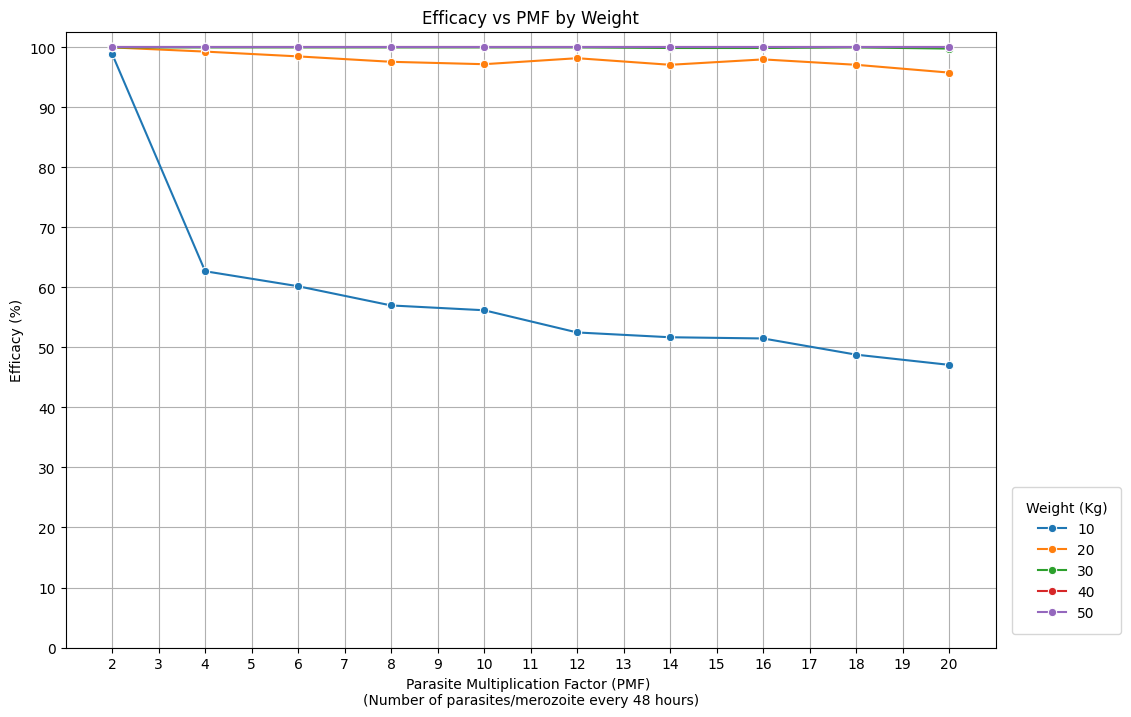

In [114]:
import seaborn as sns

# Add Scenario labels
df_efficacy_10Kg['Weight'] = '10'
df_efficacy_20Kg['Weight'] = '20'
df_efficacy_30Kg['Weight'] = '30'
df_efficacy_40Kg['Weight'] = '40'
df_efficacy_50Kg['Weight'] = '50'


# Combine them all
combined = pd.concat([
    df_efficacy_10Kg,
    df_efficacy_20Kg,
    df_efficacy_30Kg,
    df_efficacy_40Kg,
    df_efficacy_50Kg
])

plt.figure(figsize=(12, 8))
sns.lineplot(data=combined, x='PMF', y='Efficacy', hue='Weight', marker='o')
plt.title('Efficacy vs PMF by Weight')
plt.xlabel('Parasite Multiplication Factor (PMF) \n(Number of parasites/merozoite every 48 hours)')
plt.xticks(range(2, max_pmf, 1))
plt.xlim(1, 20+0.9999)

plt.ylabel('Efficacy (%)')
plt.yticks(range(0, 110, 10))

plt.grid(True)
plt.legend(title='Weight (Kg)', loc='lower right', bbox_to_anchor=(1.15, 0), title_fontsize='medium', frameon=True, fancybox=True, borderpad=1, borderaxespad=1, handlelength=2)
plt.savefig("efficacy_vs_pmf_by_weight.png", dpi=300, bbox_inches='tight')
plt.show()


<br>
<br>

---

<br>

# Plotting the evolution of killing constants for artemether and lumefantrine by weight

In [223]:
killing_constant_artemether_dataframes = []

killing_constant_lumefantrine_dataframes = []

# Read the killing constant files for each weight

for weight in [10, 20, 30, 40, 50]:
    temp_artemether = pd.read_csv(f"parasite_killing_constant_{weight}kg_artemether.txt", sep=",", header=None)
    temp_artemether.columns = [f"killing_constant_{weight}", "time(t)"]

    killing_constant_artemether_dataframes.append(temp_artemether)

    temp_lumefantrine = pd.read_csv(f"parasite_killing_constant_{weight}kg_lumefantrine.txt", sep=",", header=None)
    temp_lumefantrine.columns = [f"killing_constant_{weight}", "time(t)"]
    killing_constant_lumefantrine_dataframes.append(temp_lumefantrine)

In [225]:
df_artemether_killing_constant_10Kg = killing_constant_artemether_dataframes[0]
df_artemether_killing_constant_20Kg = killing_constant_artemether_dataframes[1]
df_artemether_killing_constant_30Kg = killing_constant_artemether_dataframes[2]
df_artemether_killing_constant_40Kg = killing_constant_artemether_dataframes[3]
df_artemether_killing_constant_50Kg = killing_constant_artemether_dataframes[4]

df_artemether_killing_constant_merged = pd.merge( df_artemether_killing_constant_10Kg, df_artemether_killing_constant_20Kg, on="time(t)", how="outer")
df_artemether_killing_constant_merged = pd.merge( df_artemether_killing_constant_merged, df_artemether_killing_constant_30Kg, on="time(t)", how="outer")
df_artemether_killing_constant_merged = pd.merge( df_artemether_killing_constant_merged, df_artemether_killing_constant_40Kg, on="time(t)", how="outer")
df_artemether_killing_constant_merged = pd.merge( df_artemether_killing_constant_merged, df_artemether_killing_constant_50Kg, on="time(t)", how="outer")

df_artemether_killing_constant_merged.head()

,killing_constant_10,time(t),killing_constant_20,killing_constant_30,killing_constant_40,killing_constant_50
0,-0.000000,0,-0.000000,-0.000000,-0.000000,-0.000000
1,0.596931,1,0.596931,0.596931,0.596931,0.596931
2,0.596931,2,0.596931,0.596931,0.596931,0.596931
3,0.596931,3,0.596931,0.596931,0.596931,0.596931
4,0.596931,4,0.596931,0.596931,0.596931,0.596931


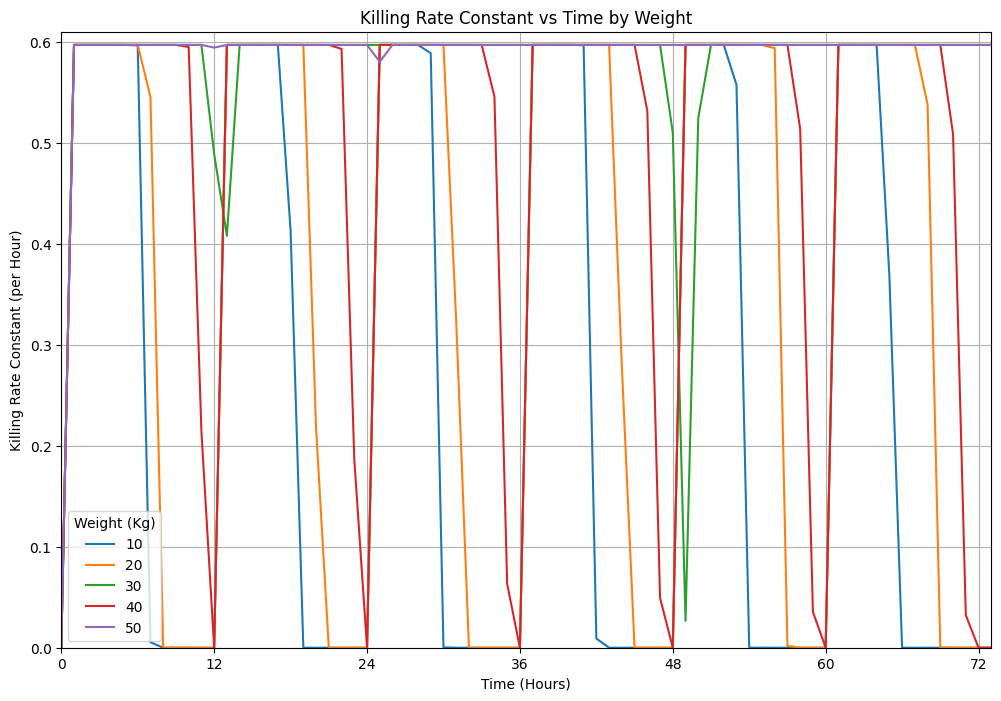

In [238]:
import matplotlib.pyplot as plt

# Define the weights
weights = [10, 20, 30, 40, 50]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each weight's killing constant
for weight in weights:
    plt.plot(
        df_artemether_killing_constant_merged["time(t)"], 
        df_artemether_killing_constant_merged[f"killing_constant_{weight}"], 
        label=f"{weight}"
    )

# Add labels, title, and legend
plt.xlabel("Time (Hours)")
plt.xticks(range(0, 3*24+1, 12))
plt.xlim(0, 3*24+1)


plt.ylabel("Killing Rate Constant (per Hour)")
plt.ylim(0, 0.61)


plt.title("Killing Rate Constant vs Time by Weight")
plt.legend(title="Weight (Kg)")
plt.grid(True)

# Show the plot
plt.show()

In [240]:
df_lumefantrine_killing_constant_10Kg = killing_constant_lumefantrine_dataframes[0]
df_lumefantrine_killing_constant_20Kg = killing_constant_lumefantrine_dataframes[1]
df_lumefantrine_killing_constant_30Kg = killing_constant_lumefantrine_dataframes[2]
df_lumefantrine_killing_constant_40Kg = killing_constant_lumefantrine_dataframes[3]
df_lumefantrine_killing_constant_50Kg = killing_constant_lumefantrine_dataframes[4]

df_lumefantrine_killing_constant_merged = pd.merge( df_lumefantrine_killing_constant_10Kg, df_lumefantrine_killing_constant_20Kg, on="time(t)", how="outer")
df_lumefantrine_killing_constant_merged = pd.merge( df_lumefantrine_killing_constant_merged, df_lumefantrine_killing_constant_30Kg, on="time(t)", how="outer")
df_lumefantrine_killing_constant_merged = pd.merge( df_lumefantrine_killing_constant_merged, df_lumefantrine_killing_constant_40Kg, on="time(t)", how="outer")
df_lumefantrine_killing_constant_merged = pd.merge( df_lumefantrine_killing_constant_merged, df_lumefantrine_killing_constant_50Kg, on="time(t)", how="outer")

df_lumefantrine_killing_constant_merged.head()

,killing_constant_10,time(t),killing_constant_20,killing_constant_30,killing_constant_40,killing_constant_50
0,-0.0,0,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
1,-0.0,1,1.124100e-15,2.040560e-12,2.414580e-10,1.634780e-10
2,-0.0,2,4.148300e-12,2.921100e-08,5.460740e-06,2.503490e-06
3,-0.0,3,2.182740e-10,5.598380e-06,1.620290e-03,5.097880e-04
4,-0.0,4,2.094750e-09,1.833300e-04,4.646650e-02,1.494370e-02


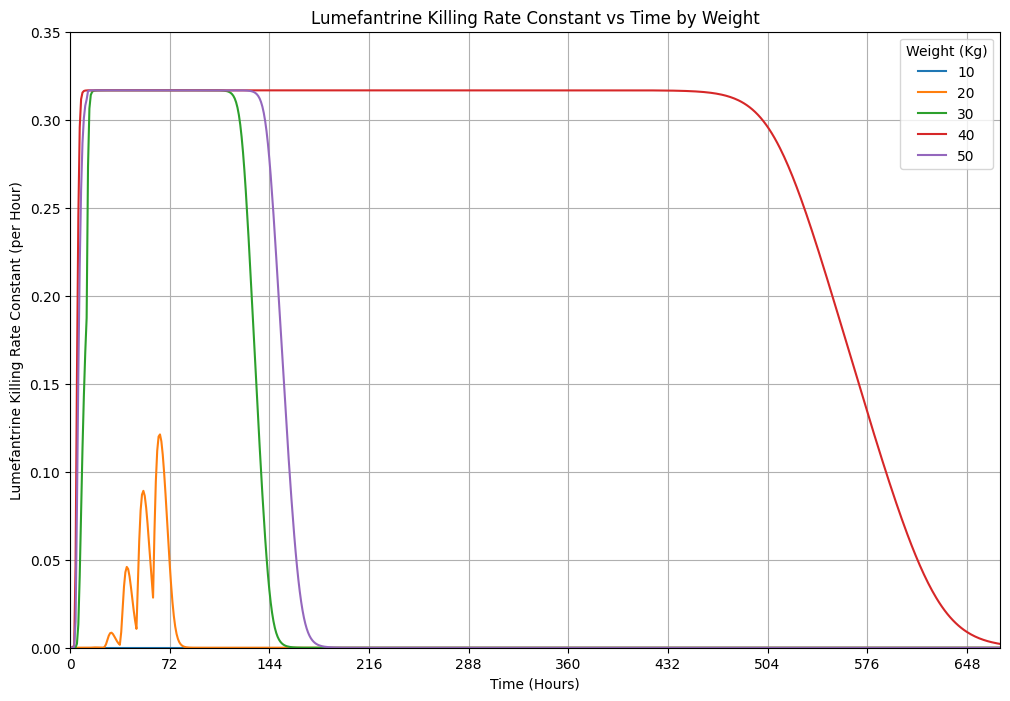

In [251]:
import matplotlib.pyplot as plt

# Define the weights
weights = [10, 20, 30, 40, 50]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each weight's killing constant
for weight in weights:
    plt.plot(
        df_lumefantrine_killing_constant_merged["time(t)"], 
        df_lumefantrine_killing_constant_merged[f"killing_constant_{weight}"], 
        label=f"{weight}"
    )

# Add labels, title, and legend
plt.xlabel("Time (Hours)")
plt.xticks(range(0, 672, 3*24))
plt.xlim(0, 672)


plt.ylabel("Lumefantrine Killing Rate Constant (per Hour)")
plt.ylim(0, 0.35)


plt.title("Lumefantrine Killing Rate Constant vs Time by Weight")
plt.legend(title="Weight (Kg)")
plt.grid(True)

# Show the plot
plt.show()